# Descriptive (Spatial) Analytics

Task: Analyze taxi demand patterns for the relevant one-year period and 
city (please check carefully which year your team has been allocated). Specifically show how these
patterns (start time, trip length, start and end location, price, average idle time between trips, and so 
on) for the given sample varies in different spatio-temporal resolution (i.e., census tract vs. varying
hexagon diameter and/or temporal bin sizes). Give possible reasons for the observed patterns

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
import h3
import h3pandas
import geopandas as gpd
import seaborn as sns

In [26]:
file_path = "./data/"

## Temporal Analysis

In [27]:
taxi_hourly = pd.read_csv(f"{file_path}taxi_hourly_processed.csv")
taxi_4hourly = pd.read_csv(f"{file_path}taxi_4_hourly_processed.csv")
taxi_daily = pd.read_csv(f"{file_path}taxi_daily_processed.csv")

In [28]:
taxi_daily

,trip_amount,mean_trip_seconds,mean_trip_miles,mean_trip_total,start_temp,start_precip,start_windspeed,end_temp,end_precip,end_windspeed
0,2758,1280.125091,6.296124,26.651613,0.890703,0.442350,10.338136,0.929808,0.435098,10.332698
1,4178,1181.376257,6.279143,24.232432,1.795412,0.000000,3.926865,1.770373,0.000000,3.927602
2,3682,1173.786257,7.609269,29.881953,0.184161,0.022271,4.619913,0.071643,0.026073,4.663781
3,5719,1139.688757,5.436548,21.120481,-1.316041,0.000000,5.855211,-1.260469,0.000000,5.884635
4,5208,1127.401498,4.959952,19.782800,0.412394,0.000000,3.953066,0.416726,0.000000,3.847389
...,...,...,...,...,...,...,...,...,...,...
360,10081,1057.591410,5.966888,26.213992,4.073064,0.052475,9.246593,3.987216,0.047614,9.291094
361,10623,1055.791208,5.827724,24.412671,2.436485,0.416455,7.541989,2.435213,0.410901,7.462087
362,11069,1059.185563,5.684680,23.336422,0.702525,0.000000,6.961707,0.702241,0.000000,6.938422
363,11302,1102.140683,5.707205,23.411620,2.314306,0.000000,3.868670,2.307747,0.000000,3.924326


### General Stats

<AxesSubplot: xlabel='trip_amount', ylabel='Count'>

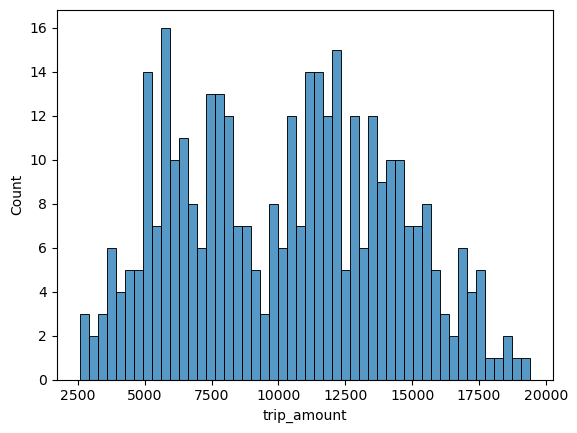

In [29]:
sns.histplot(data=taxi_daily, x="trip_amount", bins=50)

<AxesSubplot: xlabel='mean_trip_seconds', ylabel='Count'>

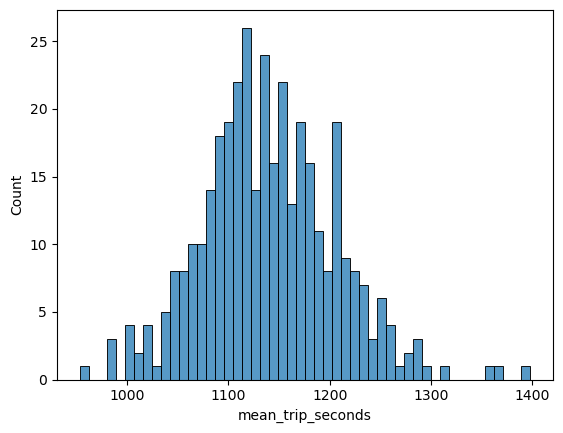

In [30]:
sns.histplot(data=taxi_daily, x="mean_trip_seconds", bins=50)

<AxesSubplot: xlabel='mean_trip_miles', ylabel='Count'>

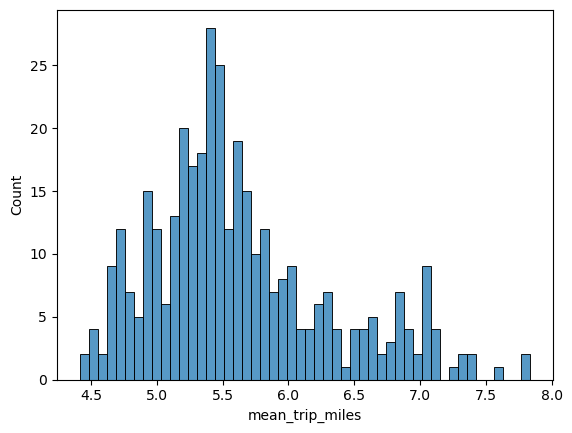

In [31]:
sns.histplot(data=taxi_daily, x="mean_trip_miles", bins=50)

<AxesSubplot: xlabel='mean_trip_total', ylabel='Count'>

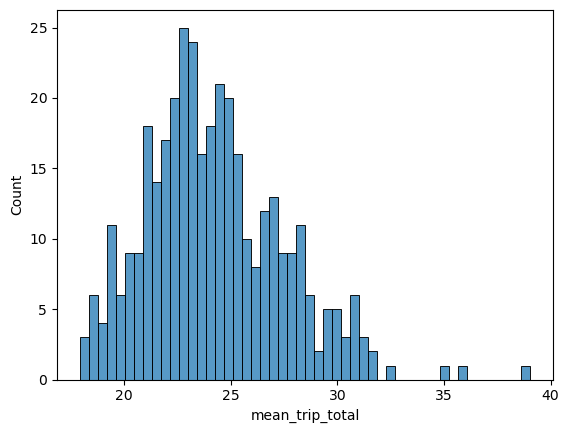

In [32]:
sns.histplot(data=taxi_daily, x="mean_trip_total", bins=50)

<AxesSubplot: xlabel='start_temp', ylabel='Count'>

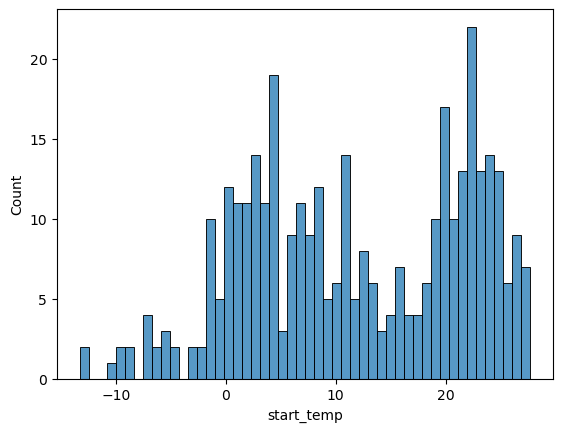

In [33]:
sns.histplot(data=taxi_daily, x="start_temp", bins=50)

<AxesSubplot: xlabel='start_precip', ylabel='Count'>

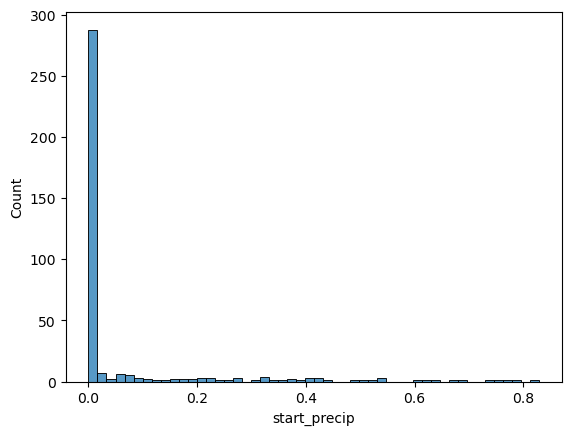

In [34]:
sns.histplot(data=taxi_daily, x="start_precip", bins=50)

### Daily Trends

<AxesSubplot: ylabel='trip_amount'>

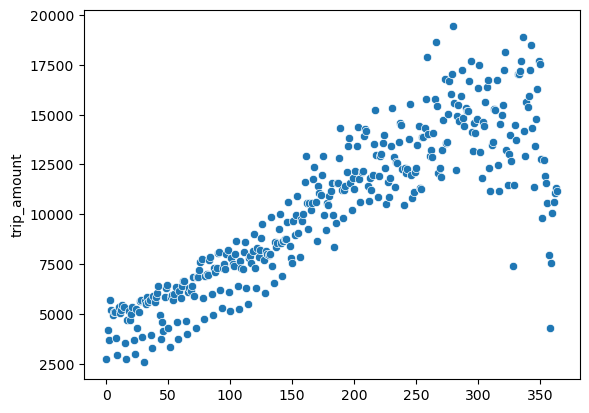

In [35]:
sns.scatterplot(data=taxi_daily, x=taxi_daily.index, y="trip_amount")

<AxesSubplot: ylabel='trip_amount'>

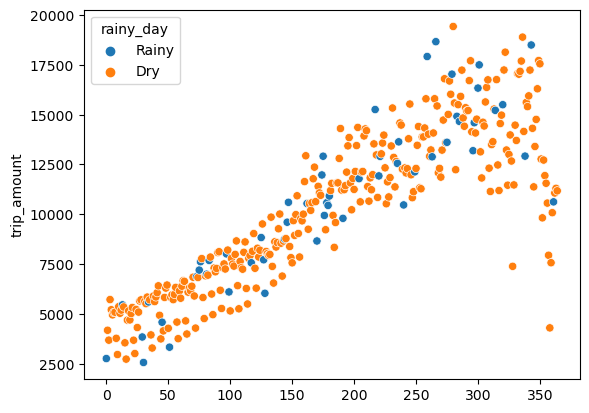

In [61]:
taxi_daily['rainy_day'] = (taxi_daily['start_precip'] >= 0.1).map({False: "Dry", True: "Rainy"})
sns.scatterplot(data=taxi_daily, x=taxi_daily.index, y="trip_amount", hue="rainy_day")

<AxesSubplot: ylabel='trip_amount'>

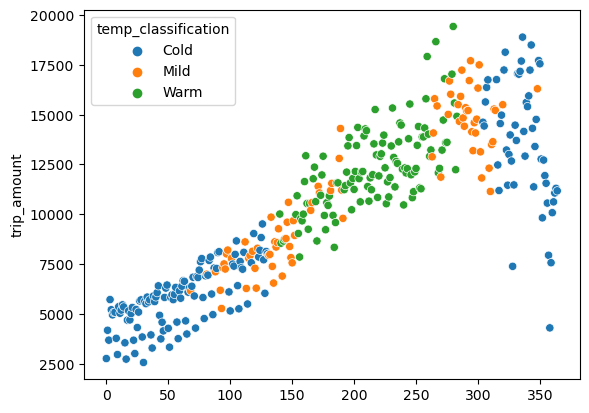

In [63]:
taxi_daily['temp_classification'] = taxi_daily["start_temp"].map(lambda x: "Warm" if x >= 20 else "Mild" if x > 10 else "Cold")
sns.scatterplot(data=taxi_daily, x=taxi_daily.index, y="trip_amount", hue="temp_classification")

<AxesSubplot: ylabel='start_temp'>

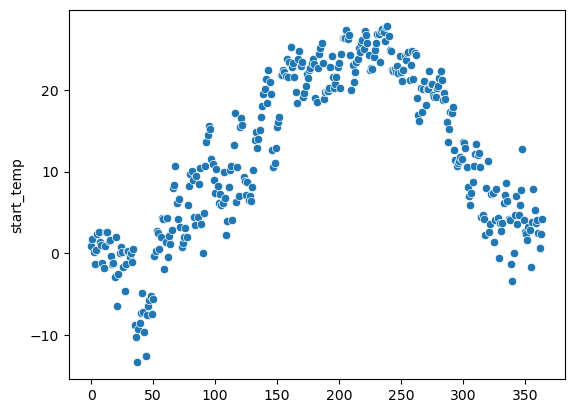

In [38]:
sns.scatterplot(data=taxi_daily, x=taxi_daily.index, y="start_temp")

<AxesSubplot: ylabel='mean_trip_seconds'>

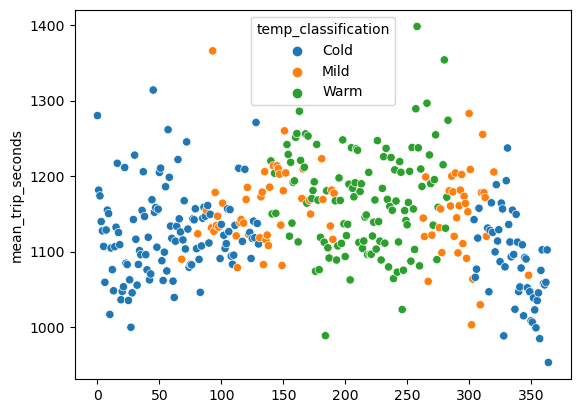

In [39]:
sns.scatterplot(data=taxi_daily, x=taxi_daily.index, y="mean_trip_seconds", hue="temp_classification")

### Inner-Day Trends

In [40]:
taxi_4hourly

,trip_amount,mean_trip_seconds,mean_trip_miles,mean_trip_total,start_temp,start_precip,start_windspeed,end_temp,end_precip,end_windspeed
0,228,1433.236842,4.697544,18.226140,-1.284868,0.000000,6.950789,-1.242982,0.004386,7.075482
1,158,950.120253,5.815570,20.895316,-0.424304,0.000000,9.201139,-0.351835,0.000000,9.411392
2,440,1054.975000,5.856864,21.924727,0.196000,0.318182,10.717455,0.266523,0.402273,10.765386
3,770,1174.900000,5.640468,30.101013,1.219013,1.000000,11.251234,1.264286,0.920779,11.291857
4,672,1353.471726,6.558080,27.010923,1.535967,0.232143,11.080551,1.522664,0.306548,10.817173
...,...,...,...,...,...,...,...,...,...,...
2185,509,945.163065,6.704617,25.400393,0.227662,0.000000,2.082731,0.331788,0.000000,2.135874
2186,1814,968.095369,5.858104,22.453870,2.828980,0.000000,4.222690,3.062624,0.000000,4.408572
2187,2984,997.779826,5.106438,21.373097,4.960747,0.000000,5.527215,5.005245,0.000000,5.560409
2188,3043,955.385475,5.450654,21.948656,5.433874,0.000000,3.499734,5.427276,0.000000,3.601410


In [41]:
taxi_4hourly["start_hour"] = taxi_4hourly.index.map(lambda x: (x % 6) * 4)
taxi_4hourly.head(10)

,trip_amount,mean_trip_seconds,mean_trip_miles,mean_trip_total,start_temp,start_precip,start_windspeed,end_temp,end_precip,end_windspeed,start_hour
0,228,1433.236842,4.697544,18.226140,-1.284868,0.000000,6.950789,-1.242982,0.004386,7.075482,0
1,158,950.120253,5.815570,20.895316,-0.424304,0.000000,9.201139,-0.351835,0.000000,9.411392,4
2,440,1054.975000,5.856864,21.924727,0.196000,0.318182,10.717455,0.266523,0.402273,10.765386,8
3,770,1174.900000,5.640468,30.101013,1.219013,1.000000,11.251234,1.264286,0.920779,11.291857,12
4,672,1353.471726,6.558080,27.010923,1.535967,0.232143,11.080551,1.522664,0.306548,10.817173,16
5,490,1582.230612,8.260408,30.759449,1.550000,0.314286,9.487265,1.611020,0.218367,9.585163,20
6,158,1120.658228,6.911139,27.320570,1.953608,0.000000,9.253291,1.894494,0.000000,8.864620,0
7,146,939.438356,6.239932,21.629178,1.379110,0.000000,4.988562,1.494795,0.000000,4.891918,4
8,774,1078.405685,5.733928,21.125478,2.251240,0.000000,3.237946,2.269083,0.000000,3.085103,8
9,1346,1194.924963,5.858886,22.823187,2.201909,0.000000,2.915691,2.138759,0.000000,3.063254,12


In [42]:
taxi_4hourly["time_of_day"] = taxi_4hourly["start_hour"].map(lambda x: "Morning" if x == 8  else "Noon" if x == 12 else "Afternoon" if x == 16 else "Evening" if x == 20 else "Night" if x == 0 else "Early Morning")
taxi_4hourly

,trip_amount,mean_trip_seconds,mean_trip_miles,mean_trip_total,start_temp,start_precip,start_windspeed,end_temp,end_precip,end_windspeed,start_hour,time_of_day
0,228,1433.236842,4.697544,18.226140,-1.284868,0.000000,6.950789,-1.242982,0.004386,7.075482,0,Night
1,158,950.120253,5.815570,20.895316,-0.424304,0.000000,9.201139,-0.351835,0.000000,9.411392,4,Early Morning
2,440,1054.975000,5.856864,21.924727,0.196000,0.318182,10.717455,0.266523,0.402273,10.765386,8,Morning
3,770,1174.900000,5.640468,30.101013,1.219013,1.000000,11.251234,1.264286,0.920779,11.291857,12,Noon
4,672,1353.471726,6.558080,27.010923,1.535967,0.232143,11.080551,1.522664,0.306548,10.817173,16,Afternoon
...,...,...,...,...,...,...,...,...,...,...,...,...
2185,509,945.163065,6.704617,25.400393,0.227662,0.000000,2.082731,0.331788,0.000000,2.135874,4,Early Morning
2186,1814,968.095369,5.858104,22.453870,2.828980,0.000000,4.222690,3.062624,0.000000,4.408572,8,Morning
2187,2984,997.779826,5.106438,21.373097,4.960747,0.000000,5.527215,5.005245,0.000000,5.560409,12,Noon
2188,3043,955.385475,5.450654,21.948656,5.433874,0.000000,3.499734,5.427276,0.000000,3.601410,16,Afternoon


<AxesSubplot: xlabel='mean_trip_miles', ylabel='Count'>

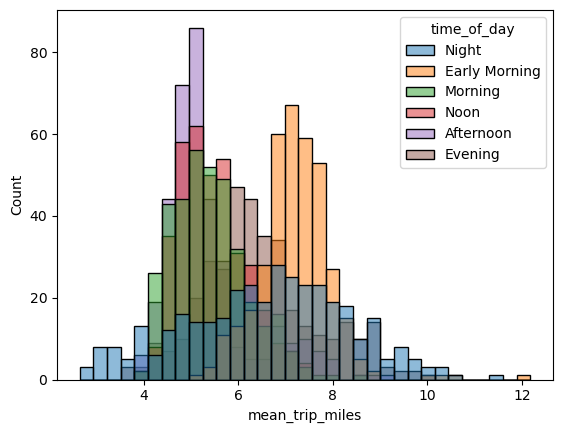

In [43]:
sns.histplot(data=taxi_4hourly, x="mean_trip_miles", hue="time_of_day")

<AxesSubplot: xlabel='mean_trip_seconds', ylabel='Count'>

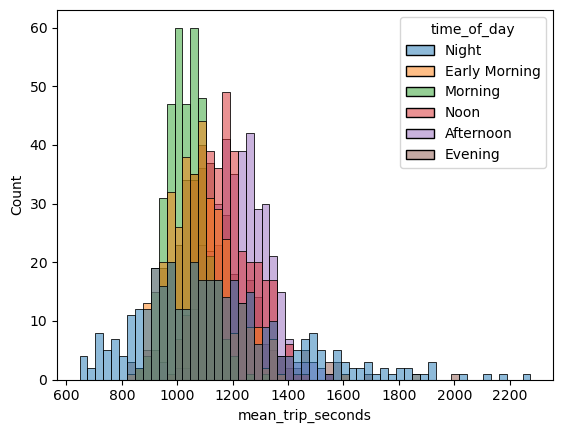

In [44]:
sns.histplot(data=taxi_4hourly, x="mean_trip_seconds", hue="time_of_day")

<AxesSubplot: xlabel='mean_trip_total', ylabel='Count'>

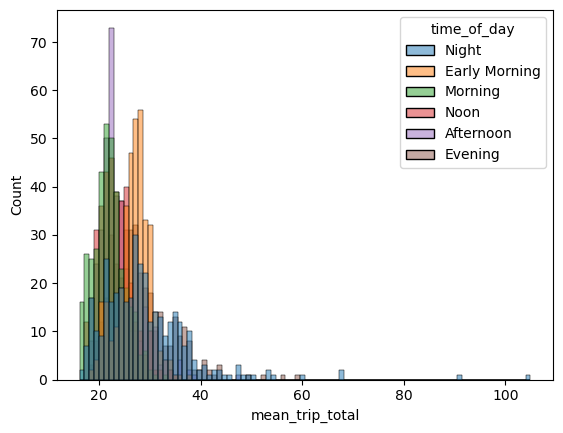

In [45]:
sns.histplot(data=taxi_4hourly, x="mean_trip_total", hue="time_of_day")

<AxesSubplot: xlabel='trip_amount', ylabel='Count'>

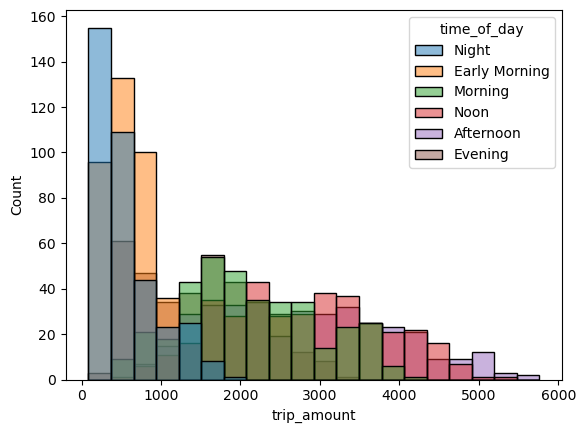

In [46]:
sns.histplot(data=taxi_4hourly, x="trip_amount", hue="time_of_day")

### Hourly Trends

In [47]:
taxi_hourly["start_hour"] = taxi_hourly.index.map(lambda x: x % 24)
taxi_hourly_agg = taxi_hourly.groupby("start_hour").agg({"trip_amount" : "sum", "mean_trip_seconds" : "mean", "mean_trip_miles" : "mean", "mean_trip_total" : "mean", "start_temp" : "mean", "start_precip" : "mean", "start_windspeed" : "mean"})
taxi_hourly_agg

,trip_amount,mean_trip_seconds,mean_trip_miles,mean_trip_total,start_temp,start_precip,start_windspeed
start_hour,,,,,,,
0,76744,1159.891392,6.836022,30.287541,10.015726,0.054795,7.417397
1,55535,1203.384321,6.611098,30.104472,9.830822,0.052055,7.300027
2,35425,1090.898678,5.958808,26.245407,9.634329,0.041096,7.180356
3,24069,1016.987829,6.509225,25.590872,9.452575,0.043836,7.065205
4,21396,1022.874228,7.910807,29.093054,9.296466,0.035616,6.949644
5,32170,1095.611553,8.299762,29.798368,9.312000,0.041096,6.838274
6,56309,1075.888945,7.660844,28.210895,9.574110,0.057534,6.694082
7,99505,1100.268393,6.748118,25.498658,10.096630,0.043836,6.596548
8,153067,1042.784437,5.763000,22.784386,10.880082,0.046575,6.667507


<AxesSubplot: xlabel='start_hour', ylabel='trip_amount'>

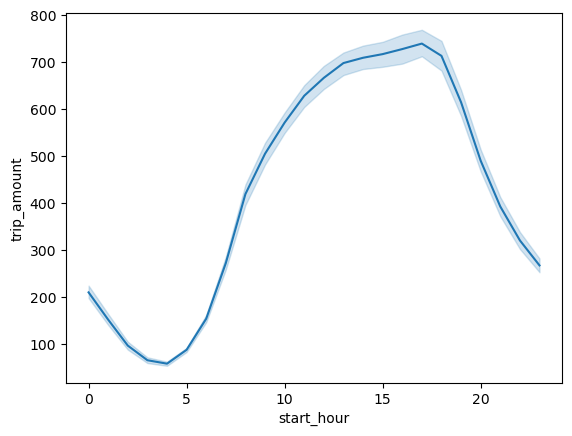

In [50]:
sns.lineplot(data=taxi_hourly, x="start_hour", y="trip_amount")

<AxesSubplot: xlabel='start_hour', ylabel='mean_trip_seconds'>

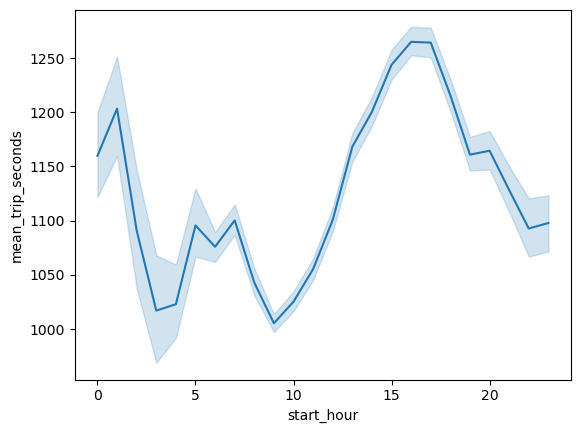

In [51]:
sns.lineplot(data=taxi_hourly, x="start_hour", y="mean_trip_seconds")

<AxesSubplot: xlabel='start_hour', ylabel='mean_trip_total'>

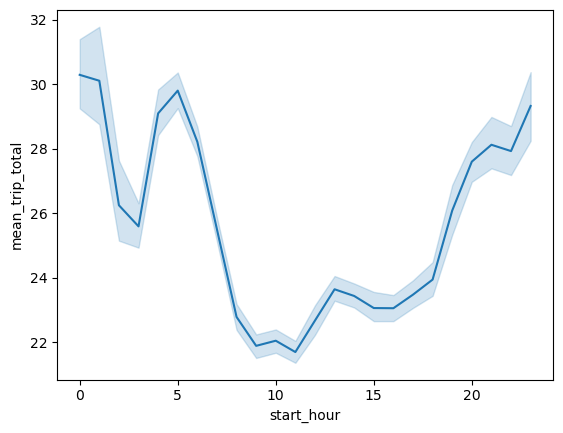

In [52]:
sns.lineplot(data=taxi_hourly, x="start_hour", y="mean_trip_total")

<AxesSubplot: xlabel='start_hour', ylabel='trip_amount'>

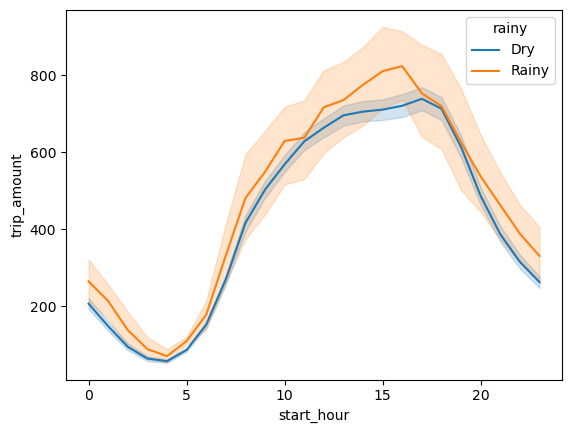

In [59]:
taxi_hourly['rainy'] = taxi_hourly["start_precip"].map(lambda x: "Rainy" if x > 0.5 else "Dry")
sns.lineplot(data=taxi_hourly, x="start_hour", y="trip_amount", hue="rainy")

<AxesSubplot: xlabel='start_hour', ylabel='trip_amount'>

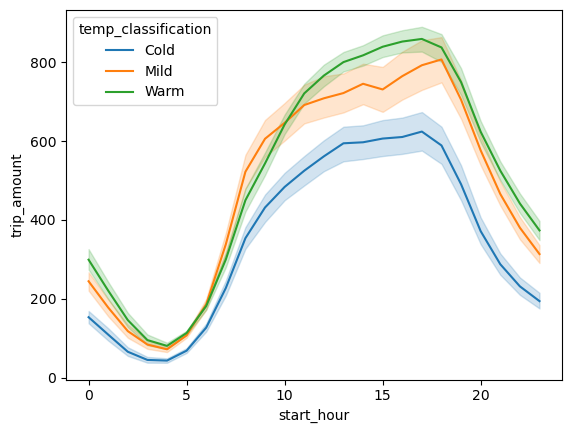

In [58]:
taxi_hourly['temp_classification'] = taxi_hourly["start_temp"].map(lambda x: "Warm" if x >= 20 else "Mild" if x > 10 else "Cold")
sns.lineplot(data=taxi_hourly, x="start_hour", y="trip_amount", hue="temp_classification")

## Spatial Analysis

In [23]:
taxi_by_census_tract = pd.read_csv(f"{file_path}taxi_by_census_tract.csv")
taxi_by_community_area = pd.read_csv(f"{file_path}taxi_by_community_area.csv")
taxi_by_h3_6 = pd.read_csv(f"{file_path}taxi_by_h3_6.csv")
taxi_by_h3_7 = pd.read_csv(f"{file_path}taxi_by_h3_7.csv")
taxi_by_h3_8 = pd.read_csv(f"{file_path}taxi_by_h3_8.csv")

In [24]:
taxi_by_census_tract['geometry'] = gpd.GeoSeries.from_wkt(taxi_by_census_tract['geometry'])
taxi_by_census_tract_gpd = gpd.GeoDataFrame(taxi_by_census_tract, geometry="geometry")
taxi_by_community_area['geometry'] = gpd.GeoSeries.from_wkt(taxi_by_community_area['geometry'])
taxi_by_community_area_gpd = gpd.GeoDataFrame(taxi_by_community_area, geometry="geometry")
taxi_h3_6_gpd = taxi_by_h3_6.set_index("h3_6_pickup").h3.h3_to_geo_boundary()
taxi_h3_7_gpd = taxi_by_h3_7.set_index("h3_7_pickup").h3.h3_to_geo_boundary()
taxi_h3_8_gpd = taxi_by_h3_8.set_index("h3_8_pickup").h3.h3_to_geo_boundary()
taxi_h3_6_gpd

,trip_amount_pickup,mean_trip_seconds,mean_trip_miles,mean_trip_total,start_temp,start_precip,start_windspeed,end_temp,end_precip,end_windspeed,trip_amount_dropoff,trip_amount_balance,geometry
h3_6_pickup,,,,,,,,,,,,,
862664197ffffff,11080,1448.481227,9.364503,30.112727,11.849060,0.055866,7.064433,11.888776,0.053971,7.082934,8240,-2840,"POLYGON ((-87.54846 41.70939, -87.59060 41.696..."
8626641b7ffffff,3066,1788.079256,8.357955,29.419416,12.557968,0.063927,7.075838,12.490652,0.065884,7.111859,1664,-1402,"POLYGON ((-87.50168 41.75446, -87.54387 41.741..."
862664527ffffff,125282,1649.224653,10.205765,48.307626,14.657493,0.067456,6.957620,14.595902,0.067280,6.978014,48922,-76360,"POLYGON ((-87.77440 41.82876, -87.81657 41.816..."
86266452fffffff,5777,2055.382205,6.949439,26.648717,12.836879,0.054873,7.019411,12.901397,0.056431,7.042484,6275,498,"POLYGON ((-87.74113 41.77636, -87.78326 41.763..."
862664567ffffff,33336,1390.357961,9.334279,29.205332,12.456111,0.052286,6.963084,12.504581,0.051776,6.979163,33319,-17,"POLYGON ((-87.62819 41.71671, -87.67030 41.704..."
86266456fffffff,3363,1417.658638,10.898814,32.374671,12.904213,0.059471,7.008201,12.932667,0.059768,7.037684,3321,-42,"POLYGON ((-87.59514 41.66433, -87.63723 41.651..."
862664577ffffff,715,1564.504895,6.697776,29.148154,13.008713,0.064336,7.118993,12.990741,0.067133,7.136713,933,218,"POLYGON ((-87.70793 41.72398, -87.75002 41.711..."
862664c17ffffff,230778,980.908579,3.468718,17.140819,13.844397,0.066198,7.048221,13.834512,0.066401,7.061548,336089,105311,"POLYGON ((-87.63414 41.96445, -87.67648 41.951..."
862664c1fffffff,1515619,787.672578,3.109567,15.698313,14.336133,0.069789,7.074435,14.319001,0.070144,7.087079,1458281,-57338,"POLYGON ((-87.60092 41.91193, -87.64322 41.899..."


In [26]:
import matplotlib.colors as colors
def plot_gpd(gpd, column, label, has_two_slope):
    if has_two_slope: 
        return gpd.plot(legend=True, column=column, figsize=(10, 10), norm=colors.TwoSlopeNorm(vmin=gpd[column].min(), vcenter=0, vmax=gpd[column].max()), cmap='RdBu', legend_kwds = {'label': label})
    else:
        return gpd.plot(legend=True, column=column, figsize=(10, 10), cmap='RdBu', legend_kwds = {'label': label})

### Trips started

<AxesSubplot: >

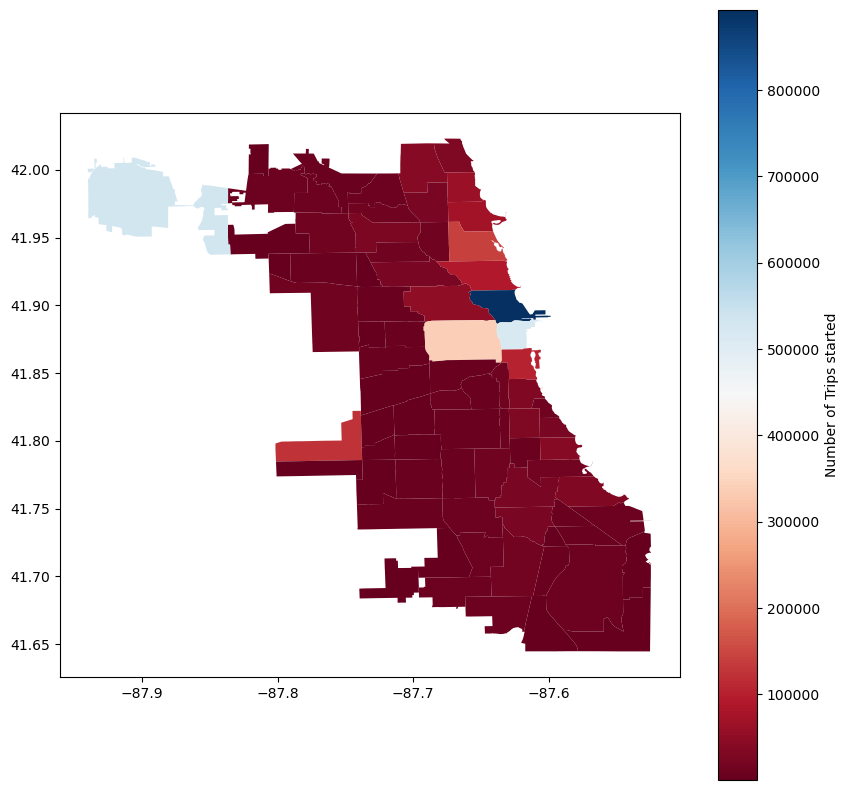

In [28]:
plot_gpd(taxi_by_community_area_gpd, "trip_amount_pickup", "Number of Trips started", False)

<AxesSubplot: >

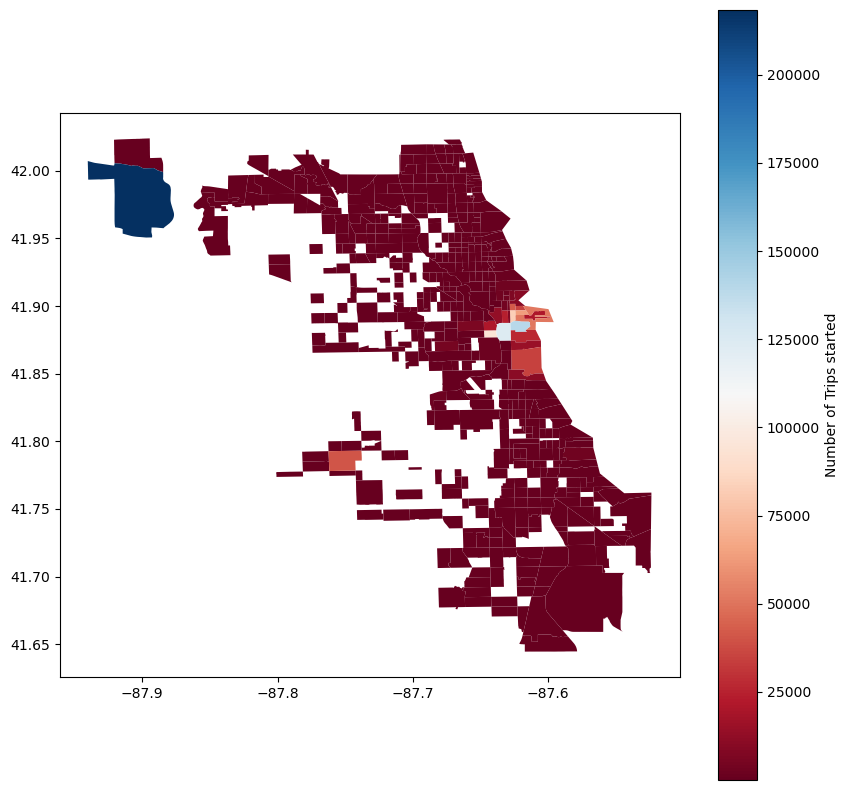

In [29]:
plot_gpd(taxi_by_census_tract_gpd, "trip_amount_pickup", "Number of Trips started", False)

<AxesSubplot: >

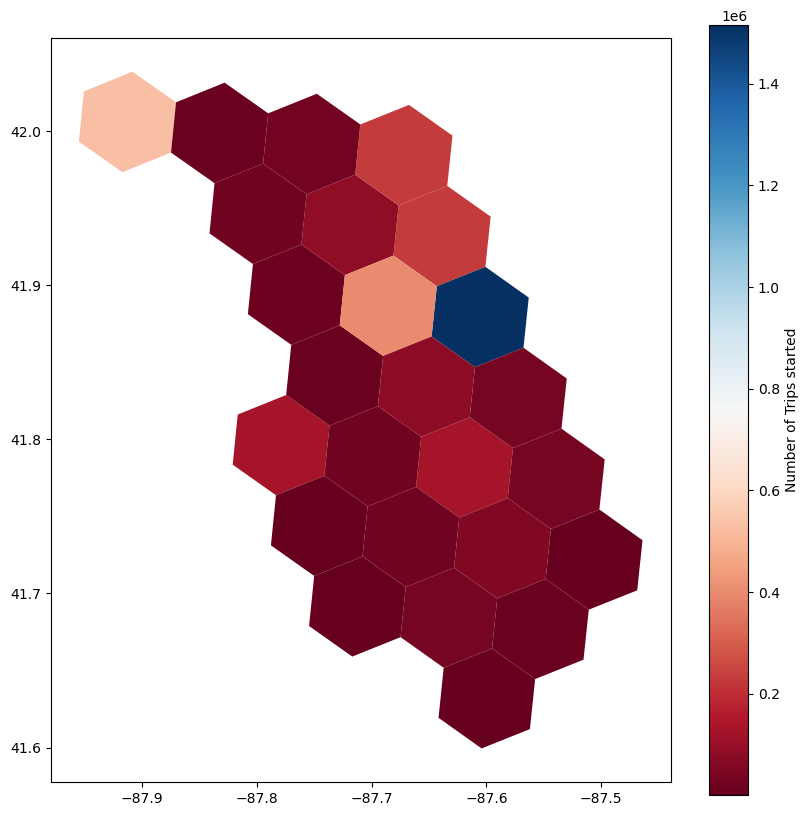

In [40]:
plot_gpd(taxi_h3_6_gpd, "trip_amount_pickup", "Number of Trips started", False)

<AxesSubplot: >

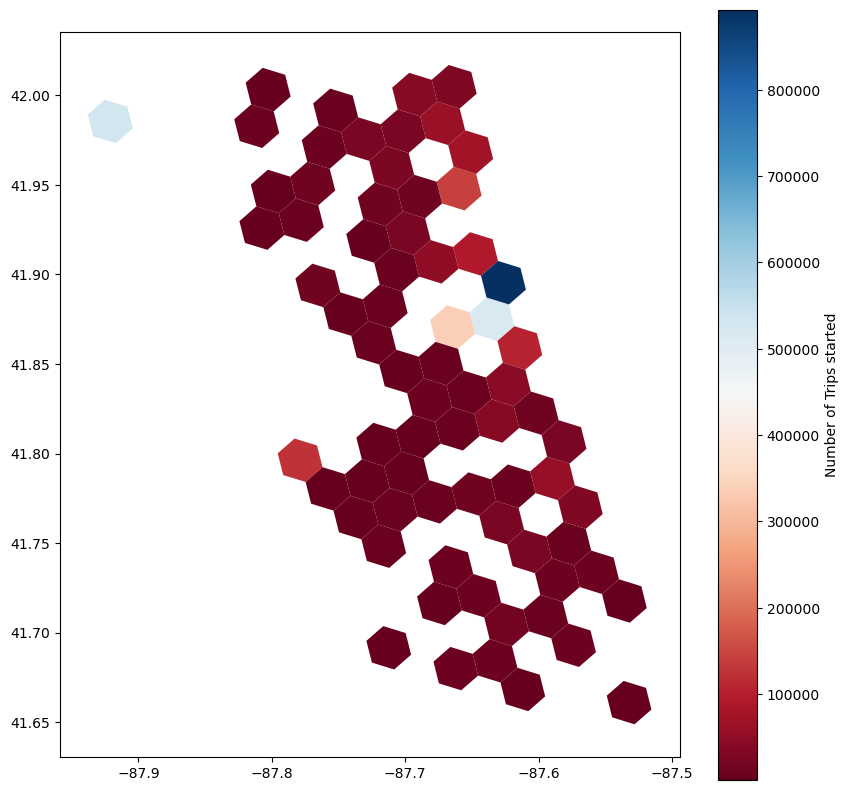

In [46]:
plot_gpd(taxi_h3_7_gpd, "trip_amount_pickup", "Number of Trips started", False)

<AxesSubplot: >

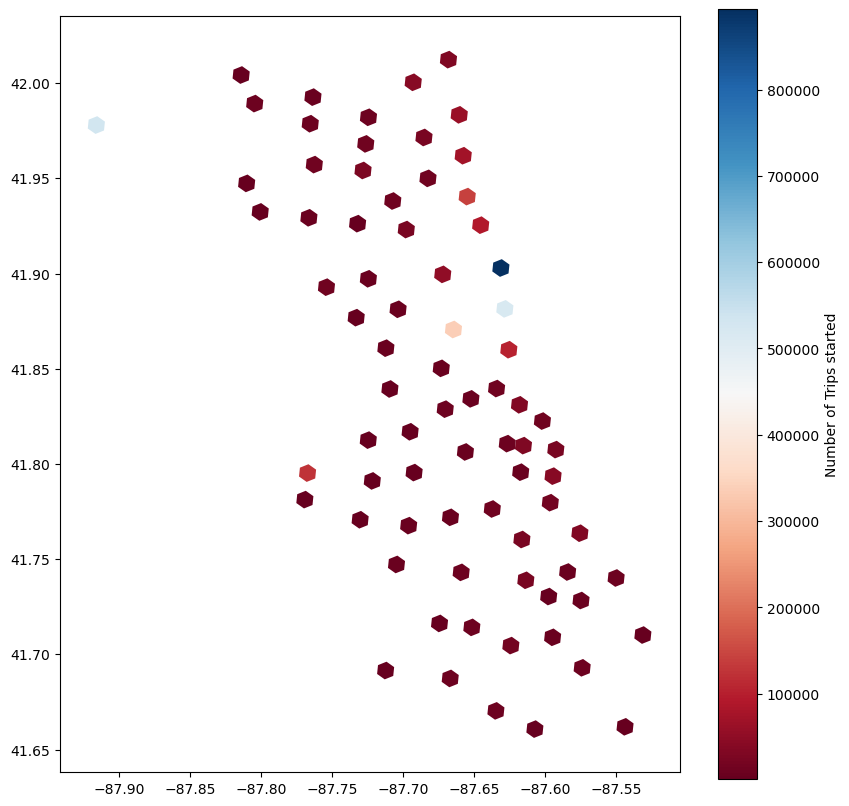

In [47]:
plot_gpd(taxi_h3_8_gpd, "trip_amount_pickup", "Number of Trips started", False)

### Trips ended

<AxesSubplot: >

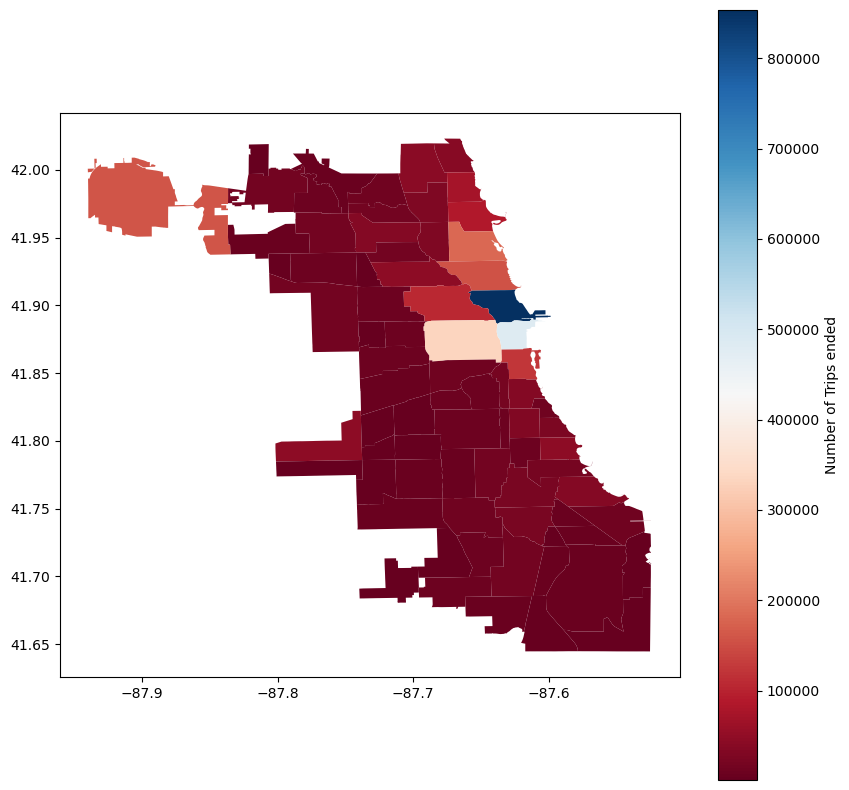

In [30]:
plot_gpd(taxi_by_community_area_gpd, "trip_amount_dropoff", "Number of Trips ended", False)

<AxesSubplot: >

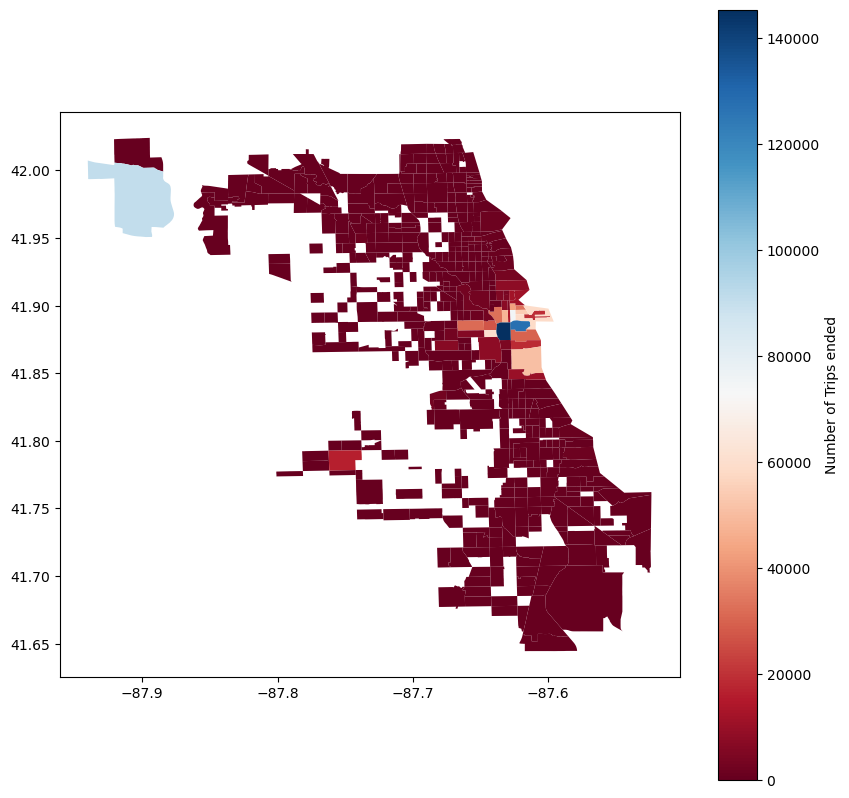

In [31]:
plot_gpd(taxi_by_census_tract_gpd, "trip_amount_dropoff", "Number of Trips ended", False)

<AxesSubplot: >

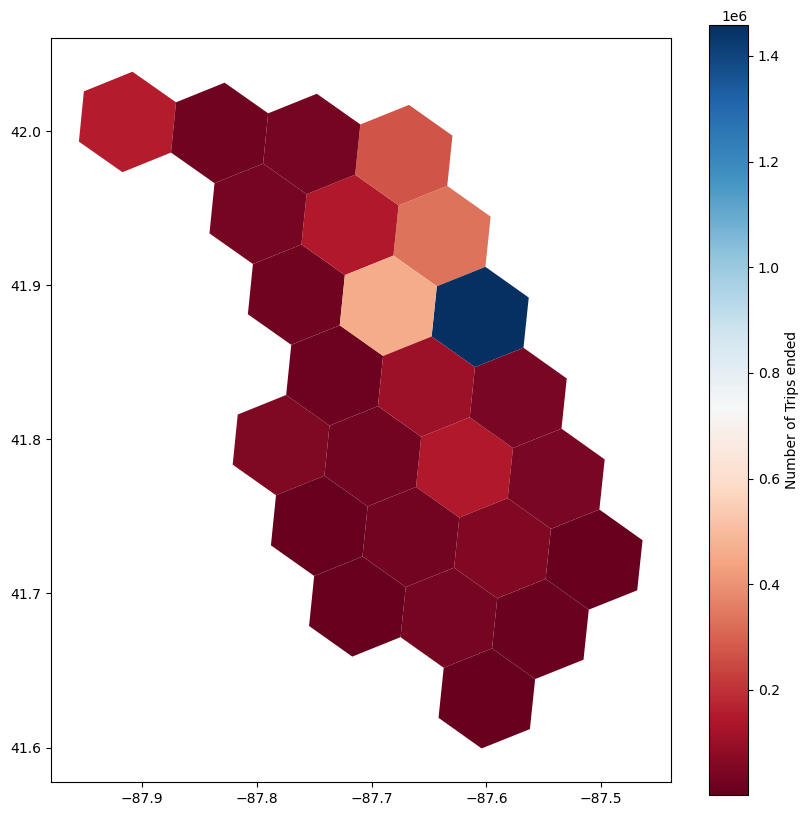

In [32]:
plot_gpd(taxi_h3_6_gpd, "trip_amount_dropoff", "Number of Trips ended", False)

<AxesSubplot: >

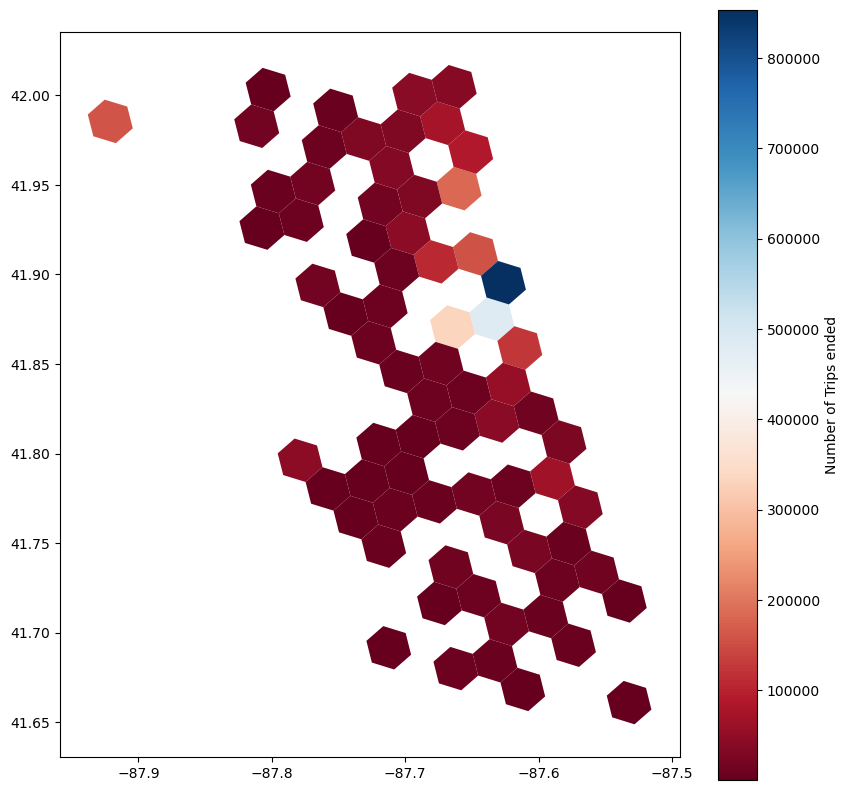

In [33]:
plot_gpd(taxi_h3_7_gpd, "trip_amount_dropoff", "Number of Trips ended", False)

<AxesSubplot: >

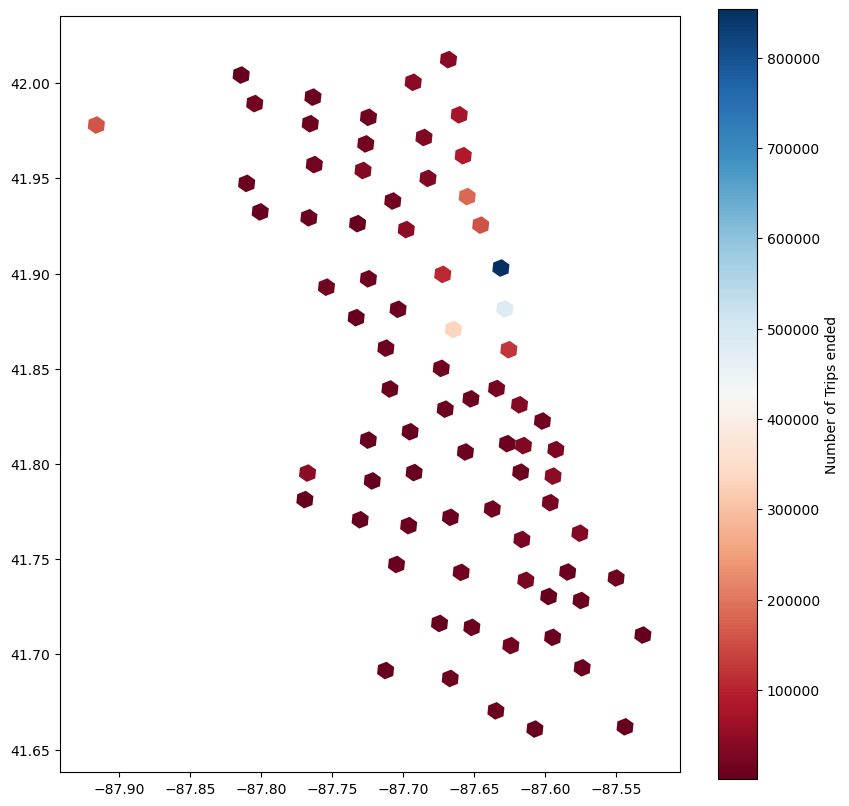

In [34]:
plot_gpd(taxi_h3_8_gpd, "trip_amount_dropoff", "Number of Trips ended", False)

### Trip balance

<AxesSubplot: >

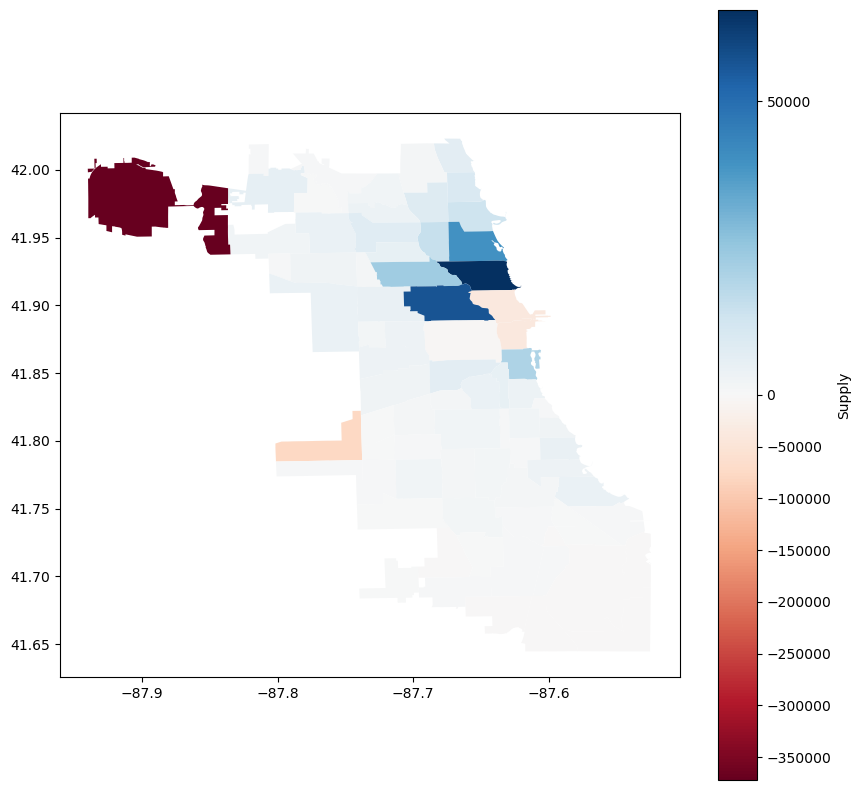

In [35]:
plot_gpd(taxi_by_community_area_gpd, "trip_amount_balance", "Supply", True)

<AxesSubplot: >

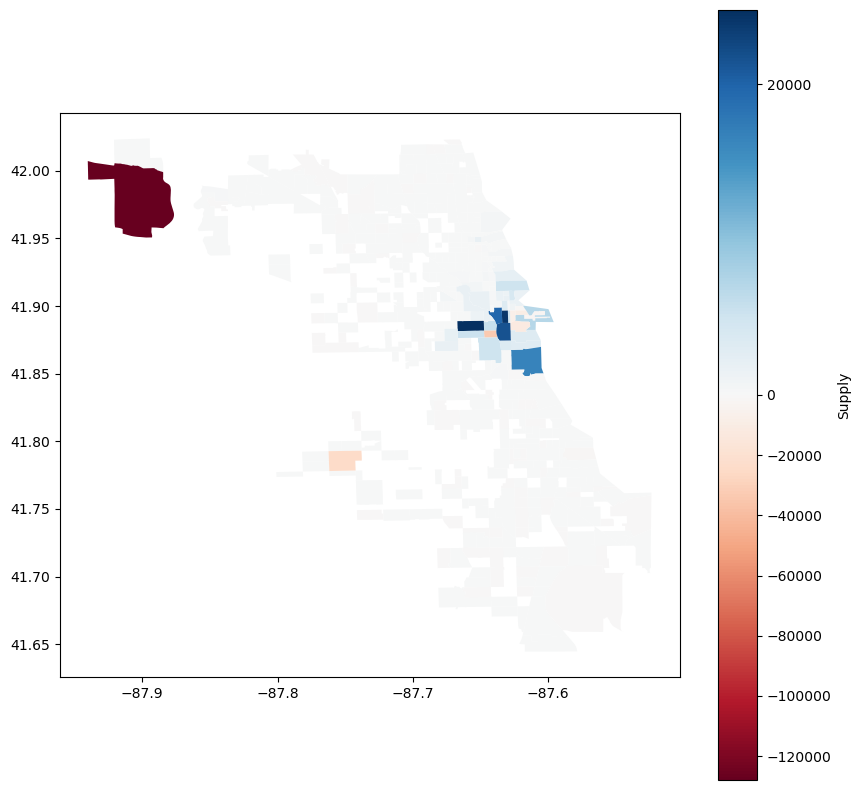

In [36]:
plot_gpd(taxi_by_census_tract_gpd, "trip_amount_balance", "Supply", True)

<AxesSubplot: >

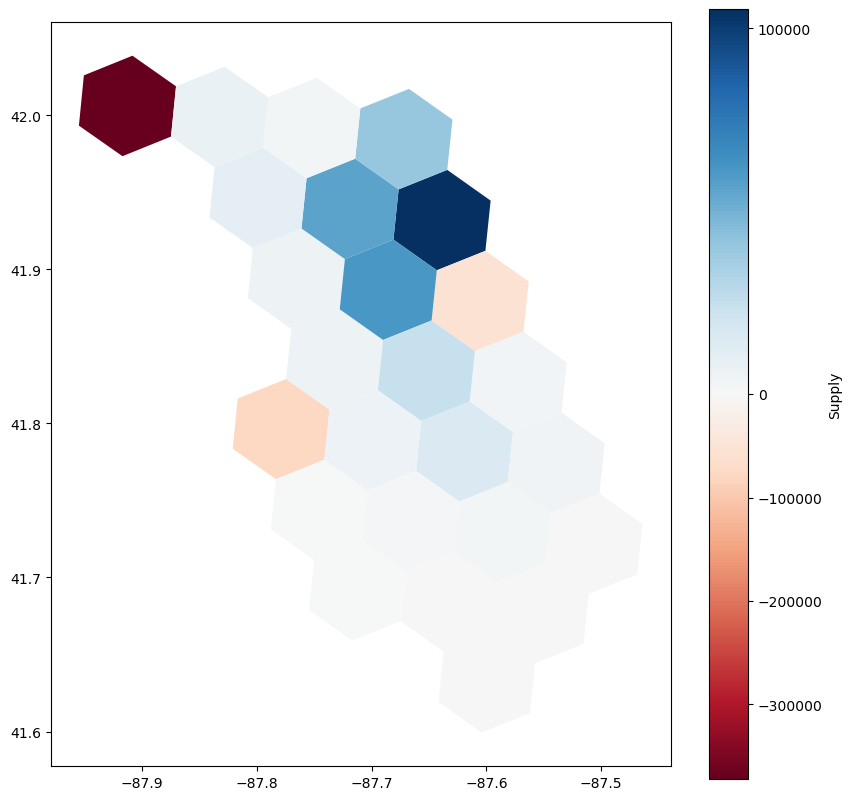

In [51]:
plot_gpd(taxi_h3_6_gpd, "trip_amount_balance", "Supply", True)

<AxesSubplot: >

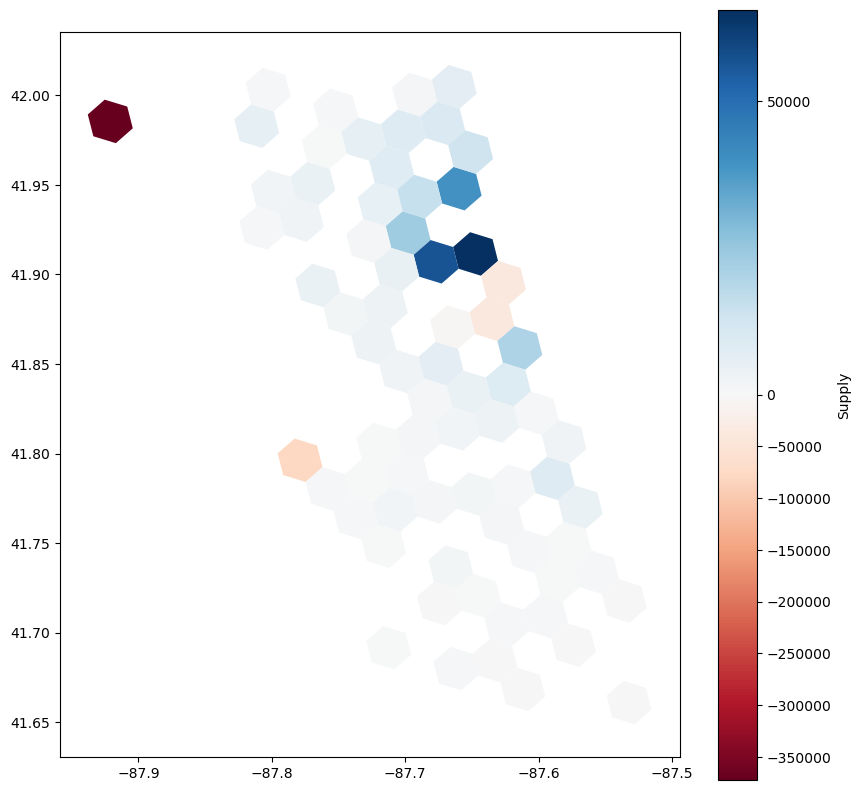

In [52]:
plot_gpd(taxi_h3_7_gpd, "trip_amount_balance", "Supply", True)

<AxesSubplot: >

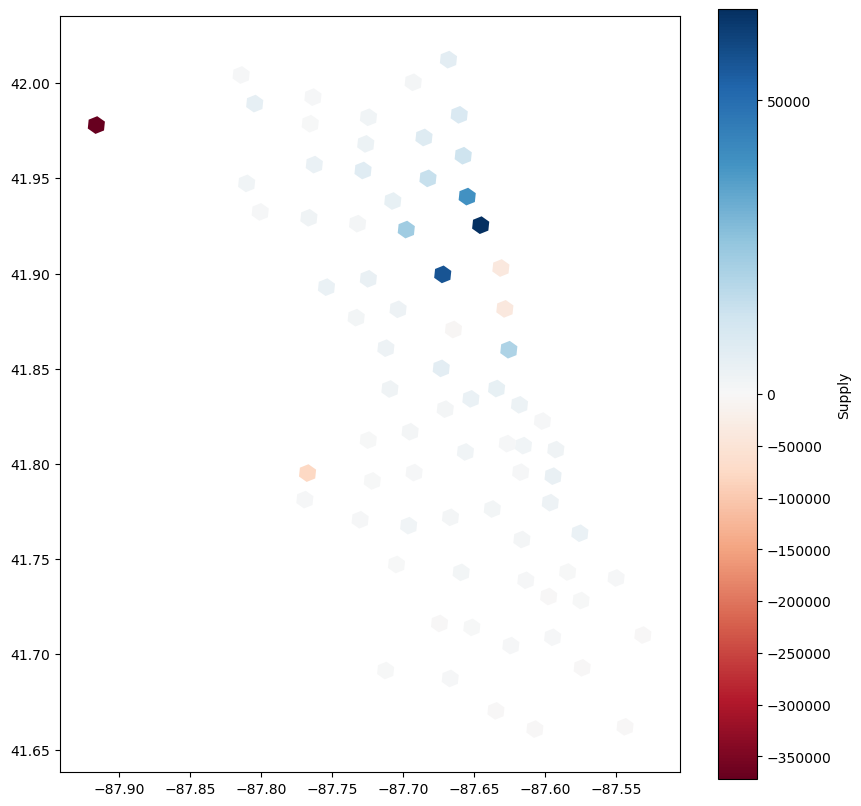

In [53]:
plot_gpd(taxi_h3_8_gpd, "trip_amount_balance", "Supply", True)

## Spatio-Temporal Analysis

In [20]:
taxi_by_census_tract_1H = pd.read_csv(f"{file_path}taxi_by_census_tract_1H.csv")
taxi_by_community_area_1H = pd.read_csv(f"{file_path}taxi_by_community_area_1H.csv")
taxi_by_h3_6_1H = pd.read_csv(f"{file_path}taxi_by_h3_6_1H.csv")
taxi_by_h3_7_1H = pd.read_csv(f"{file_path}taxi_by_h3_7_1H.csv")
taxi_by_h3_8_1H = pd.read_csv(f"{file_path}taxi_by_h3_8_1H.csv")
taxi_by_census_tract_4H = pd.read_csv(f"{file_path}taxi_by_census_tract_4H.csv")
taxi_by_community_area_4H = pd.read_csv(f"{file_path}taxi_by_community_area_4H.csv")
taxi_by_h3_6_4H = pd.read_csv(f"{file_path}taxi_by_h3_6_4H.csv")
taxi_by_h3_7_4H = pd.read_csv(f"{file_path}taxi_by_h3_7_4H.csv")
taxi_by_h3_8_4H = pd.read_csv(f"{file_path}taxi_by_h3_8_4H.csv")
taxi_by_census_tract_24H = pd.read_csv(f"{file_path}taxi_by_census_tract_24H.csv")
taxi_by_community_area_24H = pd.read_csv(f"{file_path}taxi_by_community_area_24H.csv")
taxi_by_h3_6_24H = pd.read_csv(f"{file_path}taxi_by_h3_6_24H.csv")
taxi_by_h3_7_24H = pd.read_csv(f"{file_path}taxi_by_h3_7_24H.csv")
taxi_by_h3_8_24H = pd.read_csv(f"{file_path}taxi_by_h3_8_24H.csv")

In [21]:
taxi_by_census_tract_1H

,trip_start_timestamp,pickup_census_tract,trip_amount_pickup,mean_trip_seconds,mean_trip_miles,mean_trip_total,start_temp,start_precip,start_windspeed,end_temp,end_precip,end_windspeed,trip_amount_dropoff,trip_amount_balance
0,2021-01-01 08:00:00,1.703198e+10,2.0,1883.500000,0.035000,76.375000,0.14,0.0,10.74,0.135,0.0,10.855,2.0,0.0
1,2021-01-01 11:00:00,1.703132e+10,1.0,1445.000000,17.960000,55.620000,0.37,1.0,10.70,0.370,1.0,10.700,0.0,-1.0
2,2021-01-01 12:00:00,1.703108e+10,1.0,442.000000,1.080000,9.250000,0.90,1.0,11.18,0.900,1.0,11.180,0.0,-1.0
3,2021-01-01 12:00:00,1.703128e+10,4.0,630.000000,1.800000,8.750000,0.90,1.0,11.18,0.900,1.0,11.180,4.0,0.0
4,2021-01-01 12:00:00,1.703132e+10,1.0,300.000000,1.100000,6.500000,0.90,1.0,11.18,0.900,1.0,11.180,3.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103861,2021-12-31 23:00:00,1.703133e+10,3.0,1092.666667,1.140000,14.563333,3.80,0.0,10.83,3.800,0.0,10.830,4.0,1.0
103862,2021-12-31 23:00:00,1.703183e+10,2.0,215.000000,0.320000,8.625000,3.80,0.0,10.83,3.800,0.0,10.830,1.0,-1.0
103863,2021-12-31 23:00:00,1.703184e+10,1.0,300.000000,0.800000,7.750000,3.80,0.0,10.83,3.800,0.0,10.830,6.0,5.0
103864,2021-12-31 23:00:00,1.703198e+10,11.0,1197.909091,11.591818,46.880909,3.80,0.0,10.83,3.800,0.0,10.830,0.0,-11.0
